# Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

from typing import Generator, Mapping, Tuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import functools
import matplotlib.pyplot as plt
Batch = Mapping[str, np.ndarray]

env: CUDA_VISIBLE_DEVICES=0


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mmfdipku because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Functions

## General

In [2]:
def load_dataset(dataset: str, split: str, *, is_training: bool, 
                 batch_size: int) -> Generator[Batch, None, None]:

    if dataset == "cifar10":
        ds = tfds.load("cifar10", split=split).cache().repeat()
    elif dataset == "mnist":
        ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    else:
        raise Exception("Invalid Dataset")
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))



def softmax_xent_loss(net):
    """
    Params:
        net: network function (with apply and init funcs)
    
    Returns:
        loss_fn: function(params, batch) --> loss
        
    Creates softmax cross entropy loss function for a given network
    """
    def loss(params, batch):
        logits = net.apply(params, batch)
        labels = jax.nn.one_hot(batch["label"], 10)

        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
        softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
        softmax_xent /= labels.shape[0]

        return softmax_xent + 1e-4 * l2_loss
    
    return loss 


def ptwise_grads(loss_fn):
    """
    Params:
        loss_fn: function(params, batch) --> loss 
    
    Returns:
        function(params, batch) --> pointwise gradients
    
    """
    def helper(params, batch):
        batch['image'] = jnp.expand_dims(batch['image'], axis=0)
        batch['label'] = jnp.expand_dims(batch['label'], axis=0)
        return jax.grad(loss_fn)(params, batch)
    
    return jax.vmap(helper, in_axes=(None, {'image': 0, 'label': 0}), out_axes=0)


# Returns both network and loss given net function so as to not mistakenly use incompatible functions
def network_and_loss(net_fn, rng=False):
    if not rng:
        net = hk.without_apply_rng(hk.transform(net_fn))
    else:
        net = hk.transform(net_fn)
        
    loss_fn = softmax_xent_loss(net)
    
    return net, loss_fn
    
    
    
    


## Network Architectures

In [3]:
def net_fn(batch: Batch) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    x = batch["image"].astype(jnp.float32) / 255.
    mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(300), jax.nn.relu,
      hk.Linear(100), jax.nn.relu,
      hk.Linear(10),
    ])
    return mlp(x)


def net_fn_cnn(batch: jnp.ndarray) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    x = batch["image"].astype(jnp.float32) / 255.
    cnn = hk.Sequential([
      hk.Conv2D(24,5),
      hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
      hk.Conv2D(48,5),
      hk.MaxPool(window_shape=2, strides=2, padding="VALID", channel_axis=- 1, name=None),
      hk.Flatten(),
      hk.Linear(10),
    ])
    return cnn(x)

## Training

In [4]:
def net_accuracy(net):  
    @jax.jit
    def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
        predictions = net.apply(params, batch)
        return jnp.mean(jnp.argmax(predictions, axis=-1) == batch["label"])
    return accuracy



def update_params(loss_fn):   
    @jax.jit
    def update(
      params: hk.Params,
      opt_state: optax.OptState,
      batch: Batch,
    ) -> Tuple[hk.Params, optax.OptState]:
        grads = jax.grad(loss_fn)(params, batch)
        updates, opt_state = opt.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state
    return update

# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation (cf. https://doi.org/10.1137/0330046)
@jax.jit
def ema_update(params, avg_params):
    return optax.incremental_update(params, avg_params, step_size=0.001)

def do_training(net, loss_fn, params, opt_state, train, train_eval, test_eval, epochs=10001, print_epoch=1000):

    accuracy = net_accuracy(net)
    update = update_params(loss_fn)
    avg_params = params
    
    # Train/eval loop.
    for step in range(epochs):
        if step % print_epoch == 0:
            # Periodically evaluate classification accuracy on train & test sets.
            train_accuracy = accuracy(avg_params, next(train_eval))
            test_accuracy = accuracy(avg_params, next(test_eval))
            train_accuracy, test_accuracy = jax.device_get(
              (train_accuracy, test_accuracy))
            print(f"[Step {step}] Train / Test accuracy: "
                f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

        # Do SGD on a batch of training examples.
        params, opt_state = update(params, opt_state, next(train))
        avg_params = ema_update(params, avg_params)
    
    return avg_params

## Compute Distances

In [5]:
def ravel_pytree(pytree):
    leaves, treedef = jax.tree_flatten(pytree)
    batch_size = leaves[0].shape[0]
    return jnp.concatenate([jnp.reshape(elt,(batch_size,-1)) for elt in leaves],axis=1)

def avg_sim(features,labels,classes,seq,num_iters=1000):
    
    n_classes = len(classes)
    counts = np.zeros(shape=(n_classes,n_classes))
    totals = np.zeros(shape=(n_classes,n_classes))
    
    batch_size = features.shape[0]
    
    for _ in range(num_iters):
    
        
        # sample two points, dot them
        [i,j]  = random.choice(next(seq),np.arange(batch_size),shape=(2,),replace=False)
        prod = jnp.dot(features[i],features[j])
        
        indi = classes.index(labels[i])
        indj = classes.index(labels[j])
        
        totals[indi,indj] += prod
        counts[indi,indj] += 1
    
    totals = (totals + totals.T)/2
    counts = (counts + counts.T)/2
    

    return totals/counts

# Do Stuff

# Training loop

In [6]:
# load mnist data
train = load_dataset("mnist", "train", is_training=True, batch_size=1000)
train_eval = load_dataset("mnist", "train", is_training=False, batch_size=10000)
test_eval = load_dataset("mnist", "test", is_training=False, batch_size=10000)

# cnn, loss, params
cnn, xent_loss = network_and_loss(net_fn_cnn)
params = cnn.init(jax.random.PRNGKey(42), next(train))

# optimization of network
opt = optax.adam(1e-3)
opt_state = opt.init(params)

# train cnn
final_params = do_training(cnn, xent_loss, params, opt_state, train, train_eval, test_eval, epochs=3001)

[Step 0] Train / Test accuracy: 0.094 / 0.095.
[Step 1000] Train / Test accuracy: 0.985 / 0.982.
[Step 2000] Train / Test accuracy: 0.996 / 0.990.
[Step 3000] Train / Test accuracy: 0.999 / 0.990.


## Gradient distances

In [7]:
# single, constant batch for replicable results
train = load_dataset("mnist", "train", is_training=True, batch_size=1000)
batch = next(train)

In [8]:
# compute the pointwise gradients at initial and final params
compute_pointwise_grads = ptwise_grads(xent_loss)
initial_pointwise_grads = compute_pointwise_grads(params, batch)
final_pointwise_grads = compute_pointwise_grads(final_params, batch)

In [9]:
# compute distances
initial_distances = avg_sim(ravel_pytree(initial_pointwise_grads), batch['label'], 
                            list(range(10)), hk.PRNGSequence(42))
final_distances = avg_sim(ravel_pytree(final_pointwise_grads), batch['label'], 
                            list(range(10)), hk.PRNGSequence(42))

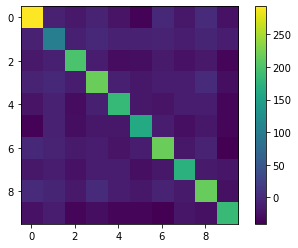

In [10]:
# initial distances
plt.imshow(initial_distances)
plt.colorbar()

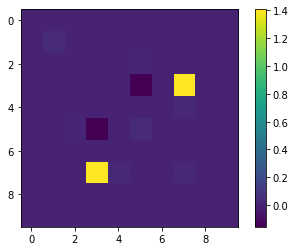

In [11]:
# final distances
plt.imshow(final_distances)
plt.colorbar()